# Work with gridded data cubes in databases 
Gridded data is saved in an sqlite database.
This notebook shows how to query the sqlite database, save the data as pandas DataFrame and do basic compuations.

In [ ]:
# loading in modules
import sqlite3
import pandas as pd

# file path
dbfile = "path/to/C_Urban_cube_v2.sqlite"

## Print table names and column names

In [ ]:
# Create a SQL connection to our SQLite database
con = sqlite3.connect(dbfile)

# creating cursor
cur = con.cursor()

# reading all table names
table_list = [
    a for a in cur.execute("SELECT name FROM sqlite_master WHERE type = 'table'")
]
# here is you table list
print(table_list)

table_name = "c_urban_cube_v2"
col_data = con.execute(f"PRAGMA table_info({table_name});").fetchall()
columns = [entry[1] for entry in col_data]
print("-------------")
print("Column names:\n")
for col in columns:
    print(col)

# Be sure to close the connection
con.close()

[('geometry_columns',), ('spatial_ref_sys',), ('c_urban_cube_v2',), ('sqlite_sequence',)]
-------------
Column names:

ogc_fid
rowid
core_city_10m
fua_ua2018_10m
ua12
ua18
areaha
ua12_code
ua12_code_l1
ua12_code_l2
ua12_code_l3
ua12_code_l4
ua18_code_l1
ua18_code_l2
ua18_code
ua18_code_l3
ua18_code_l4
cc_code_short
cc_name
cntr_code
urau_catg
urau_code
final_pop_2012cc
final_pop_2018cc
fua_code_for_cc
fua_name_for_cc
fua_code_short_for_cc
fua_code
fua_code_short
fua_name
final_pop_2012fua
final_pop_2018fua
cc_code_short_for_cz
fua_code_short_for_cz
final_pop_2012cz
final_pop_2018cz


## Example query: get Luxembourg data

In [ ]:
# Example query
query = """ 
  SELECT
    [cc_code_short],
    [cc_name],
    [UA12_code_l2],
    [UA18_code_l2],
    sum([AreaHa]) as AreaHa  
  FROM c_urban_cube_v2
  where [cc_code_short] ='LU001'
  group by [cc_code_short], [cc_name], [UA18_code_l2], [UA12_code_l2]
         """
con = sqlite3.connect(dbfile)
df = pd.read_sql(query, con)
# Be sure to close the connection
con.close()
print(df)

   cc_code_short     cc_name  \
0          LU001  Luxembourg   
1          LU001  Luxembourg   
2          LU001  Luxembourg   
3          LU001  Luxembourg   
4          LU001  Luxembourg   
5          LU001  Luxembourg   
6          LU001  Luxembourg   
7          LU001  Luxembourg   
8          LU001  Luxembourg   
9          LU001  Luxembourg   
10         LU001  Luxembourg   
11         LU001  Luxembourg   
12         LU001  Luxembourg   
13         LU001  Luxembourg   
14         LU001  Luxembourg   
15         LU001  Luxembourg   
16         LU001  Luxembourg   
17         LU001  Luxembourg   
18         LU001  Luxembourg   
19         LU001  Luxembourg   
20         LU001  Luxembourg   
21         LU001  Luxembourg   
22         LU001  Luxembourg   
23         LU001  Luxembourg   
24         LU001  Luxembourg   

                                         ua12_code_l2  \
0                          Arable land (annual crops)   
1         Artificial non-agricultural vegetated areas

## Reading full database

In [ ]:
query_urban_atlas_2018 = """
SELECT
    cc_code_short,
    cc_name,
    UA18_code_l2 as Urban_Atlas_2018_class_level2,
    sum(AreaHa) as AreaHa
FROM c_urban_cube_v2
where cc_code_short is not null
group by cc_code_short, cc_name, UA18_code_l2
         """
df_ua18 = pd.read_sql(query_urban_atlas_2018, con)
con.close()
df_ua18

----
database read...to dataframe: df_ua18
----


,cc_code_short,cc_name,Urban_Atlas_2018_class_level2,AreaHa
0,AL001,Tirana(FUA name),Arable land (annual crops),342.49
1,AL001,Tirana(FUA name),Artificial non-agricultural vegetated areas,323.72
2,AL001,Tirana(FUA name),Forests,200.75
3,AL001,Tirana(FUA name),Herbaceous vegetation associations,438.66
4,AL001,Tirana(FUA name),"Industrial, commercial, public, military, priv...",2065.43
...,...,...,...,...
10158,XK003,MitrovicÃ«(FUA name),"Industrial, commercial, public, military, priv...",127.92
10159,XK003,MitrovicÃ«(FUA name),"Mine, dump and construction sites",47.13
10160,XK003,MitrovicÃ«(FUA name),Pastures,39.85
10161,XK003,MitrovicÃ«(FUA name),Urban fabric,507.58


## Compute urban, green, agricultural and wet areas

In [ ]:
query_urban_atlas_2018_wide = """
SELECT
    cc_code_short,
    cc_name,
    UA18_code_l2 as Urban_Atlas_2018_class_level2,
    IIF(UA18_code_l2 in(
             'Urban fabric' ,
             'Industrial, commercial, public, military, private and transport units',
             'Mine, dump and construction sites'),  sum(AreaHa), 0) as urban_area,
    IIF(UA18_code_l2 in(
             'Artificial non-agricultural vegetated areas' ,
             'Forest',
             'Herbaceous vegetation associations',
             'Open spaces with little or no vegetations'
                    ), sum(AreaHa), 0) as green_area,
    IIF(UA18_code_l2 in(
            'Arable land (annual crops)',
            'Permanent crops',
            'Pastures',
            'Complex and mixed cultivation',
            'Orchards'
                    ), sum(AreaHa), 0) as agricultural_area,
    IIF(UA18_code_l2 in(
            'Wetlands',
            'water'
                    ), sum(AreaHa), 0) as wetland_and_water_area,
    sum(AreaHa) as AreaHa
FROM c_urban_cube_v2
where cc_code_short is not null
group by cc_code_short, cc_name, UA18_code_l2
order by cc_name,UA18_code_l2
         """
df_ua18_wide = pd.read_sql(query_urban_atlas_2018_wide, con)
con.close()

print("database read...to dataframe: df_ua18_wide")
df_ua18_wide

----
database read...to dataframe: df_ua18_wide


,cc_code_short,cc_name,Urban_Atlas_2018_class_level2,urban_area,green_area,agricultural_area,wetland_and_water_area,AreaHa
0,NL503,'s-Hertogenbosch,Arable land (annual crops),0.00,0.00,1540.90,0.0,1540.90
1,NL503,'s-Hertogenbosch,Artificial non-agricultural vegetated areas,0.00,797.20,0.00,0.0,797.20
2,NL503,'s-Hertogenbosch,Forests,0.00,0.00,0.00,0.0,635.02
3,NL503,'s-Hertogenbosch,Herbaceous vegetation associations,0.00,9.73,0.00,0.0,9.73
4,NL503,'s-Hertogenbosch,"Industrial, commercial, public, military, priv...",2056.16,0.00,0.00,0.0,2056.16
...,...,...,...,...,...,...,...,...
10158,SK006,Å½ilina,"Industrial, commercial, public, military, priv...",1048.09,0.00,0.00,0.0,1048.09
10159,SK006,Å½ilina,"Mine, dump and construction sites",96.26,0.00,0.00,0.0,96.26
10160,SK006,Å½ilina,Pastures,0.00,0.00,1241.57,0.0,1241.57
10161,SK006,Å½ilina,Urban fabric,1140.18,0.00,0.00,0.0,1140.18


## Calculate percentage of urban and green areas

In [ ]:
df_ua18_sum = (
    df_ua18_wide.groupby(["cc_code_short", "cc_name"])
    .agg(
        urban_area=("urban_area", "sum"),
        green_area=("green_area", "sum"),
        AreaHa=("AreaHa", "sum"),
    )
    .reset_index()
)

df_ua18_sum["per_green"] = 100 / df_ua18_sum["AreaHa"] * df_ua18_sum["green_area"]
df_ua18_sum["per_urban_area"] = 100 / df_ua18_sum["AreaHa"] * df_ua18_sum["urban_area"]

df_ua18_sum

,cc_code_short,cc_name,urban_area,green_area,AreaHa,per_green,per_urban_area
0,AL001,Tirana(FUA name),7562.63,777.01,10190.86,7.624577,74.209929
1,AL003,Elbasan(FUA name),711.81,69.75,1100.00,6.340909,64.710000
2,AL004,ShkodÃ«r(FUA name),713.96,48.34,1200.00,4.028333,59.496667
3,AT001,Wien,20603.65,5272.13,41484.89,12.708555,49.665432
4,AT002,Graz,7007.02,525.52,12866.85,4.084294,54.457929
...,...,...,...,...,...,...,...
1037,UK585,Renfrewshire (Paisley),6419.28,5155.10,26250.31,19.638244,24.454111
1038,UK586,Derry & Strabane Local Government District,0.00,0.00,124881.72,0.000000,0.000000
1039,XK001,Pristina(FUA name),1572.31,107.04,2200.00,4.865455,71.468636
1040,XK002,Prizren(FUA name),1144.48,78.43,1800.00,4.357222,63.582222


## Example clustering using percent of urban area and green area

/home/conda/fairicube/509ef1ea91778cd89e0732da937c672a0e4c27fd9e360fadaa9831b15c3fb15c-20230123-091006-736556-1-edc-2022.10-14/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


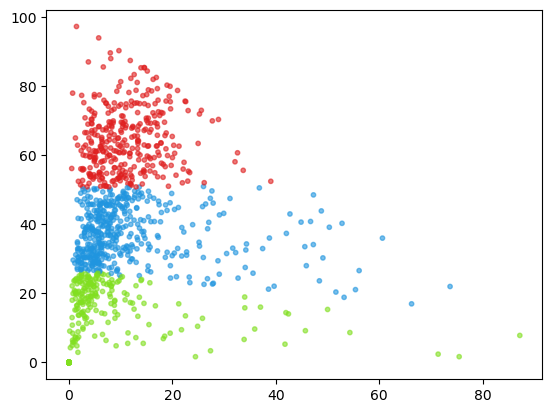

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# k means clustering
df = df_ua18_sum
kmeans = KMeans(n_clusters=3, random_state=0)
df["cluster"] = kmeans.fit_predict(
    df[["per_green", "per_urban_area"]]
)  # AreaHa = defence
# get centroids
centroids = kmeans.cluster_centers_
cen_x = [i[0] for i in centroids]
cen_y = [i[1] for i in centroids]
## add to df
df["cen_x"] = df.cluster.map({0: cen_x[0], 1: cen_x[1], 2: cen_x[2]})
df["cen_y"] = df.cluster.map({0: cen_y[0], 1: cen_y[1], 2: cen_y[2]})
# define and map colors
colors = ["#DF2020", "#81DF20", "#2095DF"]
df["c"] = df.cluster.map({0: colors[0], 1: colors[1], 2: colors[2]})

plt.scatter(df.per_green, df.per_urban_area, c=df.c, alpha=0.6, s=10)

## Make ratios table with level-2 classes

In [ ]:
# Create a SQL connection to our SQLite database
con = sqlite3.connect(dbfile)
query_urban_atlas_2018 = """
SELECT
    cc_code_short,
    cc_name,
    UA18_code_l2 as Urban_Atlas_2018_class_level2,
    sum(AreaHa) as AreaHa
FROM c_urban_cube_v2
where cc_code_short is not null
group by cc_code_short, cc_name, UA18_code_l2
         """
df_ua18 = pd.read_sql(query_urban_atlas_2018, con)
con.close()
df_ua18

,cc_code_short,cc_name,Urban_Atlas_2018_class_level2,AreaHa
0,AL001,Tirana(FUA name),Arable land (annual crops),342.49
1,AL001,Tirana(FUA name),Artificial non-agricultural vegetated areas,323.72
2,AL001,Tirana(FUA name),Forests,200.75
3,AL001,Tirana(FUA name),Herbaceous vegetation associations,438.66
4,AL001,Tirana(FUA name),"Industrial, commercial, public, military, priv...",2065.43
...,...,...,...,...
10158,XK003,MitrovicÃ«(FUA name),"Industrial, commercial, public, military, priv...",127.92
10159,XK003,MitrovicÃ«(FUA name),"Mine, dump and construction sites",47.13
10160,XK003,MitrovicÃ«(FUA name),Pastures,39.85
10161,XK003,MitrovicÃ«(FUA name),Urban fabric,507.58


In [ ]:
# compute ratios
ratios = (
    df_ua18[["cc_code_short", "AreaHa"]]
    .groupby(["cc_code_short"], group_keys=False)
    .apply(lambda x: x / x.sum())
)
ratios.rename(columns={"AreaHa": "Ratio"}, inplace=True)
df_ua18_r = df_ua18.join(ratios)
# check if ratios sum up to 1
df_ua18_r.groupby(["cc_code_short"], group_keys=False).sum(numeric_only=True)

,ua18_code,AreaHa,Ratio
cc_code_short,,,
AL001,302720.0,10190.86,1.0
AL003,237060.0,1100.00,1.0
AL004,269540.0,1200.00,1.0
AT001,262900.0,41484.89,1.0
AT002,175620.0,12866.85,1.0
...,...,...,...
UK585,207650.0,26250.31,1.0
UK586,0.0,124881.72,1.0
XK001,158040.0,2200.00,1.0


In [ ]:
# long to wide df
df_ua18_r_wide = df_ua18_r.pivot(
    index="cc_code_short", columns="Urban_Atlas_2018_class_level2", values="Ratio"
)
df_ua18_r_wide

Urban_Atlas_2018_class_level2,NaN,Arable land (annual crops),Artificial non-agricultural vegetated areas,Complex and mixed cultivation,Forests,Herbaceous vegetation associations,"Industrial, commercial, public, military, private and transport units","Mine, dump and construction sites",Open spaces with little or no vegetations,Orchards,Pastures,Permanent crops,Urban fabric,Water,Wetlands
cc_code_short,,,,,,,,,,,,,,,
AL001,NaN,0.033608,0.031766,NaN,0.019699,0.043044,0.202675,0.052761,0.001436,NaN,0.107324,0.001142,0.486664,0.013398,0.006484
AL003,NaN,0.045618,0.009464,0.003182,0.217436,0.030509,0.149400,0.016309,0.023436,NaN,0.019618,0.003636,0.481391,NaN,NaN
AL004,NaN,0.010125,0.010650,NaN,0.023083,0.029633,0.109458,0.005167,NaN,NaN,0.310900,0.000892,0.480342,0.015167,0.004583
AT001,NaN,0.117406,0.126555,NaN,0.182028,0.000383,0.205815,0.012881,0.000148,NaN,0.031319,0.009746,0.277959,0.035760,NaN
AT002,NaN,0.040916,0.040843,NaN,0.261324,NaN,0.183955,0.009674,NaN,NaN,0.105050,NaN,0.350951,0.007288,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UK585,NaN,0.045596,0.059119,NaN,0.087621,0.137264,0.106352,0.025102,NaN,NaN,0.408855,NaN,0.113087,0.017005,NaN
UK586,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
XK001,NaN,0.191227,0.040168,NaN,0.003500,0.008486,0.261182,0.027236,NaN,NaN,0.041932,NaN,0.426268,NaN,NaN


In [ ]:
# save dataset
output_folder = r"./../../../s3/Machine Learning/"
# df_ua18_r_wide.to_csv(output_folder+'city_UrbanAtlas_l2_ratios.csv', index=True)